In [16]:
from pathlib import Path
import torch
import numpy as np
from skimage import io
import os
import sys

sys.path.insert(0, '../src')
%matplotlib inline

In [5]:
from data.dataset import getTrainValSplit, getTransforms, MatteDataset
from architecture.linknet import LinkNet34
from architecture.refinement_layer import MatteRefinementLayer

%load_ext line_profiler

In [10]:
PATH = Path('../data/processed/train')
BG = PATH/'bg'
FG = PATH/'fg'
MASKS = PATH/'mask'

In [11]:
train_fns, val_fns = getTrainValSplit(BG)
data_transform = getTransforms()
image_datasets = {'train': MatteDataset(train_fns, root_dir=PATH, fg_path=FG, transform=data_transform),
                  'val': MatteDataset(val_fns, root_dir=PATH, fg_path=FG, transform=data_transform)}

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ln = LinkNet34(1)
mrl = MatteRefinementLayer()
ln.load_state_dict(torch.load('../models/modelv0_16.pt'))
mrl.load_state_dict(torch.load('../models/refinev0_16.pt'))
ln = ln.to(device)
mrl = mrl.to(device)

In [14]:
idx = 3
sample = image_datasets['train'][idx]
imap = sample['im_map']
img = imap[:3,:,:]
tri = imap[3,:,:]
m = sample['mask']
fg = sample['fg']
imap.shape, m.shape, tri.shape, fg.shape

(torch.Size([4, 320, 320]),
 torch.Size([1, 320, 320]),
 torch.Size([320, 320]),
 torch.Size([3, 320, 320]))

### Input Image

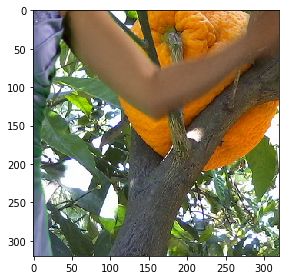

In [17]:
image = (img.numpy().transpose(1,2,0)*255).astype(np.uint8)
io.imshow(image)

### Input Trimap

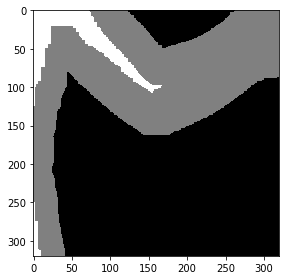

In [18]:
trimap = (tri.numpy()*255).astype(np.uint8)
io.imshow(trimap)

In [19]:
trimap.shape

(320, 320)

### Ground-Truth Matte

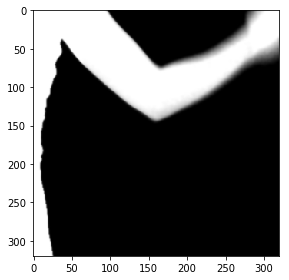

In [20]:
gt_matte = (m.numpy()[0]*255).astype(np.uint8)
io.imshow(gt_matte)

### Predicted Matte

In [23]:
inp = imap.unsqueeze(0).to(device)
out = ln(inp)
pm = mrl(torch.cat((inp[:,:3,:,:], out), 1))
pmn = (pm[0][0].cpu().detach().numpy()*255).astype(np.uint8)

In [24]:
# Comment-in to use information from trimap

# pmn[np.equal(tri, 1).numpy().astype(np.bool)] = 255
# pmn[np.equal(tri, 0).numpy().astype(np.bool)] = 0

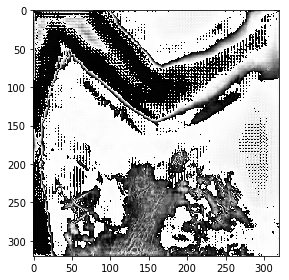

In [25]:
io.imshow(pmn)

### Foreground

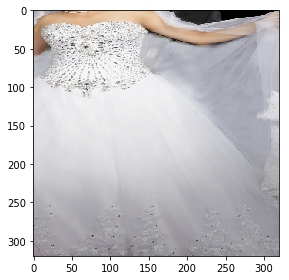

In [67]:
fore = (fg.numpy().transpose(1,2,0)).astype(np.uint8)
io.imshow(fore)

### Predicted Foreground

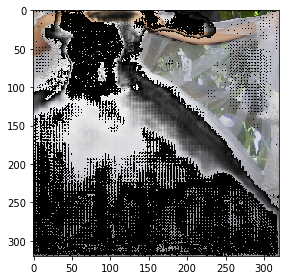

In [68]:
p_fore = np.multiply(image, (1/255)*np.expand_dims(pmn, -1)).astype(np.uint8)
io.imshow(p_fore)